# Structured Optimization


# 1 - Data and Library Loading

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from sklearn.cluster import KMeans
random.seed(1)

1/ Load and plot the training data. Which model seems to have generated the data? In particular, how many "centroids" can you count?

### Ans1

The data seems to have been generated by a mixture of Gaussian distributions. I can Count Three centroids.

In [3]:
data_train = np.genfromtxt('train.dat', delimiter=" ", dtype='f8')
data_test = np.genfromtxt('test.dat', delimiter=" ", dtype='f8')
n_point, n_dimension = data_train.shape
n_state = 4

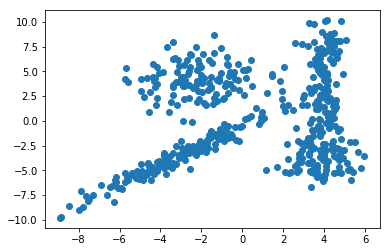

In [4]:
plt.scatter(data_train[:,0], data_train[:,1])
plt.show()

# 2 First approach: k-means algorithm

2/ Use the $k$-means algorithm in order to cluster the data into $K$ classes stored in vector $z\in\{0,1,2,3\}^T$. Return the vector $\tau \in \{0,1\}^{T \times K}$ such that
$
\tau_{t,k} = 
\begin{cases}
1 & \text{if}\;\;z_t=k\\
0 & \text{otherwise}.
\end{cases}
$

Hint: use the $\texttt{sklearn}$ library.

In [5]:
sklearn??


In [6]:
def kmeans(x, K):
    """
    inputs:
    x : [T,D], T points of dimension D 
    K : integer, number of clusters
    outputs:
    tau [T,k] output, one-hot encoding of the clustering in k classes
    """
    T = x.shape[0]
    kmeans = KMeans(n_clusters=K, random_state=0).fit(x)
    z = kmeans.labels_
    tau = np.zeros((T, K),dtype='f8')
#     for t in range (T):
#         for k in range (K):
#             if z[t]==k:
#                 tau[t,k]=1
    a = sklearn.preprocessing.LabelBinarizer()
    tau = a.fit_transform(z)
    #FILL TAU
    return tau

3/ Compute and plot the k-means affectation for $K=4$. <font color=red> What assumption of the $k$-means algorithm is not well-suited to the data?

### Ans3
K-Means clustering method considers two assumptions regarding the clusters:
- first that the clusters are spherical:helps in separating the clusters when the algorithm works on the data and forms clusters and the clusters are of similar size: helps in deciding the boundaries of the cluster.

- The assumption that each datatpoint belongs to one and only cluster . this is not suited for the data because sometimes one datapoint can belong to many clusters with different proportions.

- the assumption that there are only a fixed k number classes or clusters in the data. This is not well suited as there could be more or less clusters than what we see initially and then the model will adapt to the number initially chosen k while the reality is different.


In [7]:
def plot_affectation(x, cluster_indices):
    colors = ['k', 'r', 'g', 'b']
    markers = [ 'o', 's', '+', 'x']
    for i_state in range(n_state):
        plt.scatter(x[cluster_indices==i_state,0], x[cluster_indices==i_state,1], c=colors[i_state], marker=markers[i_state])

In [8]:
def clusterindices(x):
    N,D=x.shape
    cluster =np.zeros(N)
    for i in range(N):
        for j in range(D):
            if x[i,j]==1:                
                cluster[i]=j
    return cluster
K=4
tau= kmeans(data_train,K)

cluster=clusterindices(tau)

#print(cluster)

#plot_affectation(data_train,cluster)
plot_affectation(data_train,np.argmax(tau,1))

# 3 EM-algorithm for the Gaussian Mixture Model

We first model the data by a Gaussian Mixture Model (GMM): the observed data is comprised of $T$ i.i.d random variables $X_t \mapsto \mathbb{R}^{2}$  which follow a mixture of $K$ Gaussians. The choice of the Gaussian component in the mixture is determined by a latent variable $Z_t \mapsto \{0,\cdots,K-1\}$ following a multinomial distribution.
To each entry $t \in [0,\cdots,T-1]$ we associate an observation $x_t$ and a latent variable $z_t$, and denote by $x\in \mathbb{R}^{T \times 2}$ the vector of $T$ observations and $z\in \{0,\cdots,K-1\}^{T}$ a corresponding vector of latent variables.

$$
p(x,z) = \prod_{t=0}^{T-1} p(x_t,z_t) = \prod_{t=0}^{T-1} p(z_t) p(x_t \mid z_t)~.
$$

The latent variables follow each a multinomial distribution parameterized by $\pi \in \mathbb{R}^K$: 
$$
p(z_t=k) = \pi_k~.
$$
The conditional probability $p(x_t \mid z_t=k)$ follows a Gaussian distribution parameterized by the centroid $\mu_k \in \mathbb{R}^{2}$ and covariance  matrix $\Sigma_k \in \mathbb{R}^{ 2 \times 2}$:
$$
p(x_t\mid z_t=k) \sim \frac1{(2\pi)^{D/2} \mid\Sigma_i\mid^{1/2}}
\exp{\left(-\frac12(x_t-\mu_k)^\intercal \Sigma_k^{-1} (x_t-\mu_k)\right)},
$$

5 / Draw the model in plate notation.

6 / Complete the function $\texttt{log_gaussian}(x, mu, Sigma)$ which returns the logarithm of the emission probability of value $x$ by a normal distribution parameterized by $\mu$ and $\Sigma$. Run the test cell to check if your code is correct.

Hint: use `np.linalg.det` and `np.linalg.inv`

In [9]:
def log_gaussian(x, mu, Sigma):
    """
    inputs:
    x : [T,D], input T points of dimension D
    mu : [D,], centroid
    Sigma : [D,D], centroid
    outputs:
    float, log probability of x being generated by the gaussian N(mu, sigma)
    """
    T, D= x.shape
    diff = x-mu  # shape T x D
    
    A = -(D/2) * np.log(2*np.pi) - np.log(np.linalg.det(Sigma))/2
    
    B = np.diag(0.5*(diff @ np.linalg.inv(Sigma) @ diff.T))

    return A-B

In [10]:
#the next assert checks the correcteness of the log-gaussian function's code! the assert must pass
mu = np.array([1,1])

Sigma = np.array([[1,0.5],[0.3,2]])

x = np.array([[1,0],[10,1]])

assert((np.abs(log_gaussian(x, mu, Sigma)-np.array([ -2.41574016, -45.92925367]))<1e-8).all())

8 / Complete the function $\texttt{log_all_gaussians}(x, mus, Sigmas)$ which returns $p(x_t \mid z_t=k)$ for all the $k$ Gaussian distributions parameterized by $\mu_k$ and $\Sigma_k$:
$$
[p]_{t,k}=p(x_t \mid z_t=k)
$$

In [11]:
def log_all_gaussians(x, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    [T,K]  probability that each data point x_t was generated by the k-th mixture
    """
    
    n_state = mus.shape[0]
    
    log_proba = np.zeros((x.shape[0], n_state),dtype='f8')
    
    for i_state in range(n_state):
        
        log_proba[:,i_state] = log_gaussian(x,mus[i_state,:],Sigmas[i_state,:,:])
        
    return log_proba

In [12]:
#another code check
mus = np.array([[1,1],[5,5]])
Sigmas = np.array([[[1,0.5],[0.3,2]],[[2,0.5],[0.9,2]]])
x = np.array([[1,0],[10,1]])
print(log_all_gaussians(x,mus,Sigmas).shape)
assert((np.abs(log_all_gaussians(x, mus, Sigmas)-np.array([[ -2.41574016, -10.07698467], [-45.92925367, -17.96430861]]))<1e-7).all())

(2, 2)


6 / Complete the function $\texttt{M_step_mixture}$ which implements the M-step of an EM algorithm for a GMM model. This function returns the parameters $\hat{\pi},\hat{\mu}, \hat{\Sigma}$ learnt from the expected latent variables $\tau_{t,k}=p(z_t=k \mid x; \theta_\text{current})$.

Reminder:
$$
\hat{\pi}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k}}{T} 
$$
$$
\hat{\mu}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k} x_k}{\sum_{t=0}^{T-1} \tau_{t,k}} 
$$
$$
\hat{\Sigma}_k = \frac{\sum_{t=0}^{T-1}\tau_{t,k} (x_t-\hat{\mu_k})(x_t-\hat{\mu_k})^\intercal}{\sum_{t=0}^{T-1} \tau_{t,k}} 
$$

In [13]:
#M-step
def M_step_mixture(x, tau):
    """
    x : [T,D] T input points of dimension D
    tau : [T,K] expected latent variable
    outputs:
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    """
    T,D= x.shape
    
    pi = np.zeros((n_state,),dtype='f8')
    
    mus = np.zeros((n_state, n_dimension),dtype='f8')
    
    Sigmas = np.zeros((n_state, n_dimension, n_dimension),dtype='f8')
    
    tau_sum  = tau.sum(0)
    
    pi = tau_sum/T
    
    mus = (tau.T @ x)/(tau_sum[:,None])
    
    for k_state in range(n_state):
       
        x_diff = np.sqrt(tau[:,k_state])[:,None] * (x - mus[k_state,:][None,:]) 
        
       # x_diff = np.sqrt(tau[:,k_state]) * (x - mus[k_state,:]) [None,:]
        
        Sigmas[k_state,:,:] = (x_diff.T @ x_diff)/tau_sum[k_state]
        
        
    return pi, mus, Sigmas

5/ Compute $\pi, (\mu_k, \Sigma_k)_k, $ with the value of $\tau$ obtained with $k$-means. Use the function $\texttt{plot_model}(\tau, mus, Sigmas)$ to represent the iso-density contour of each Gaussians. <font color=red> Why does it make sens to use the $\tau$ from k-means with an M-step to compute the parameters of the Gaussians.

### Ans
at M-step we are computing the new parameters just  by taking  the center-of gravity of the data that the Gaussian is responsible for. Just like in K-means, except the data is weighted by the posterior probability of the Gaussian. 

Since the EM algorithm converges after a considerable number of iterations, it always makes a local maximum and not the global one. It is therefore important to use  initial parameter close to  optimal value. for this reason, by initializing with parameters of $\tau$ from k-means gives a much higher probability of converging to a good local maximum. 

In [14]:
def plot_model(x, tau, mus, Sigmas):
    def plot_gaussian(mu, Sigma):
        x, y = np.meshgrid(np.linspace(-10, 10, 100),
                       np.linspace(-10, 10, 100))
        def gauss(x,y): return np.exp(log_gaussian(np.array([x,y])[None,:], mu, Sigma)[0])
        vec_gaussian = np.vectorize(gauss)
        plt.contour(x, y, vec_gaussian(x, y),3)
    plt.clf()
    colors = ['k', 'r', 'g', 'b']
    markers = [ 'o', 's', '+', 'x']
    z = tau.argmax(1)
    for k_state in range(n_state):
        plt.scatter(x[z==k_state,0], x[z==k_state,1], c=colors[k_state], marker=markers[k_state])
        plot_gaussian(mus[k_state,:], Sigmas[k_state,:,:])

In [15]:
tau=kmeans(data_train, 4)
pi, mus, Sigmas = M_step_mixture(data_train, tau)
plot_model(data_train, tau, mus, Sigmas)

print(Sigmas)

[[[ 2.18737545  0.09978376]
  [ 0.09978376  2.77892178]]

 [[ 2.1193328  -0.86025175]
  [-0.86025175  4.19922107]]

 [[ 3.83569104  3.73784217]
  [ 3.73784217  4.00361041]]

 [[ 0.58744018  0.47741776]
  [ 0.47741776  6.12683473]]]


7/ Complete the function $\texttt{logsumexp}(X)=\log(\sum_k(\exp(X_k)))$ which compute the logarithm of sum on the last dimension of elementwise exponentials of an array in a robust way. Try it on the example below, and explain why the naive approach doesn't work.

<font color=red> Justify why this might be necessary when handling normal distributions.

### Ans:
With the naive method, one can quickly face numerical precision problems when the calculated values of which are very large or very small. As we can see in the following cells, while we get infinity with the naive method, the robust method always gives us a number. Especially when calculating joint probabilities for normal distributions, they may tend to grow exponentially small or large. The naive method's output values may therefore go to infinity in most cases and this is the issue the $\texttt{logsumexp}$  function resolves.

In [16]:
def logsumexp(x):
    """
    #compute log(sum(exp(x))) avoiding numerical underflow
    """    
    max_per_line = x.max(-1, keepdims=True)
    return (max_per_line + np.log(np.sum(np.exp(x-max_per_line),-1, keepdims=True))).squeeze()

In [17]:
test_value = np.array([-1000, -2000, -1001])
naive = np.log(np.sum(np.exp(test_value)))
robust = logsumexp(test_value)
print("naive = %f / robust = %f" % (naive, robust))

naive = -inf / robust = -999.686738


/usr/lib/python3/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


7 / Complete the function $\texttt{E_step_mixture}(x, \pi, mus, Sigmas)$ which returns the expected latent values $\tau_{t,k}=p(z_t=k \mid x: \theta_\text{current})$ given by the mixture parameterization $\pi, (\mu_k, \Sigma_k)_k$. <font color='red'> Prove that <font color='black'>:
$$
p(z_t=k \mid x; \theta_\text{current})=\frac{p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}{\sum_{k=0}^{K-1} p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}
$$

### Ans
$$p(z_t=k \mid x; \theta_\text{current}) \text{ is the posterior of the distribution, According to Baye's rule, Posterior} = \frac{likelihood * prior}{evidence}$$

$$\text{likelihood} = p(x_t \mid z_t=k; \theta_\text{current})$$

$$\text{prior} = p(z_t=k; \theta_\text{current})$$

$$\text{In this case evidence} = p(x_t; \theta_\text{current}) =  \sum_{k} (\text{likelihood * prior}) \text{ because we are working with discrete variables}$$

$$p(x_t; \theta_\text{current}) = \sum_{k=0}^{K-1} p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})$$

$$p(z_t=k \mid x; \theta_\text{current})=\frac{p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}{p(x_t; \theta_\text{current})}$$

So  $$
p(z_t=k \mid x; \theta_\text{current})=\frac{p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}{\sum_{k=0}^{K-1} p(x_t \mid z_t=k; \theta_\text{current})\;p(z_t=k; \theta_\text{current})}
$$



In [18]:
def E_step_mixture(x, pi, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    tau : [T,K] expected latent variable
    """
    A= log_all_gaussians(x,mus,Sigmas) + np.log(pi)
    
    tau= A - logsumexp(A)[:, None]
    
    print(tau.shape)
    
    return np.exp(tau)

In [19]:
#check that the taus are probabilities
tau = E_step_mixture(data_train, pi, mus, Sigmas)
assert((np.abs(tau.sum(1)-1)<1e-8).all())

(500, 4)


8 / Complete the function $\texttt{avg_log_likelihood_mixture}(x)=\log(p(x;\theta_\text{current}))$ which returns the loglikelihood of the vector of observations  $x$ given a Gaussian mixture model parameterized by $\pi, (\mu_k, \Sigma_k)_k$ and normalized by the number of observations.
$$
L(x;\theta_\text{current})=\frac1T \sum_{t=0}^{T-1}\log(p(x_t;\theta_\text{current}))=\frac1T \sum_{t=0}^{T-1}\log\left(\sum_{k=0}^{K-1} p(x_t,z_t=k;\theta_\text{current})\right)
$$

In [20]:
def avg_log_likelihood_mixture(x, pi, mus, Sigmas):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi : [K,] the Multinomial parameters of z
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    outputs:
    log-likelihood of x
    """
    log_tau_unnormalized = log_all_gaussians(x, mus, Sigmas) + np.log(pi[None,:])#actually did it for you, nothing to complete
    return (logsumexp(log_tau_unnormalized).sum()) / x.shape[0]

9 / Implement the EM algorithm to learn the mixture parameters $\pi, (\mu_k, \Sigma_k)_k$ from the training set with $K=4$. Initialize with $k$-means. Print the likelihood at each step, what do we observe?

In [21]:
def EM_mixture(x):
    """
    inputs:
    x : [T,D] T input points of dimension D
    outputs:
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    tau : [T,K] expected latent variable
    """
    n_ite = 50
    #first E-step
    tau = kmeans(x, 4)
    #main loop
    for i_ite in range(n_ite):
        #M-step
        pi, mus, Sigmas = M_step_mixture(x,tau)
        #E-step
        tau = E_step_mixture(x,pi,mus,Sigmas)
        #likelihood
        print("Mixture iteration %d  - loglikelihood = %1.3f" % (i_ite,avg_log_likelihood_mixture(x,pi,mus,Sigmas)))
    return pi, mus, Sigmas, tau

(500, 4)
Mixture iteration 0  - loglikelihood = -4.784
(500, 4)
Mixture iteration 1  - loglikelihood = -4.712
(500, 4)
Mixture iteration 2  - loglikelihood = -4.678
(500, 4)
Mixture iteration 3  - loglikelihood = -4.669
(500, 4)
Mixture iteration 4  - loglikelihood = -4.665
(500, 4)
Mixture iteration 5  - loglikelihood = -4.662
(500, 4)
Mixture iteration 6  - loglikelihood = -4.660
(500, 4)
Mixture iteration 7  - loglikelihood = -4.659
(500, 4)
Mixture iteration 8  - loglikelihood = -4.658
(500, 4)
Mixture iteration 9  - loglikelihood = -4.657
(500, 4)
Mixture iteration 10  - loglikelihood = -4.657
(500, 4)
Mixture iteration 11  - loglikelihood = -4.656
(500, 4)
Mixture iteration 12  - loglikelihood = -4.656
(500, 4)
Mixture iteration 13  - loglikelihood = -4.656
(500, 4)
Mixture iteration 14  - loglikelihood = -4.656
(500, 4)
Mixture iteration 15  - loglikelihood = -4.656
(500, 4)
Mixture iteration 16  - loglikelihood = -4.656
(500, 4)
Mixture iteration 17  - loglikelihood = -4.656
(5

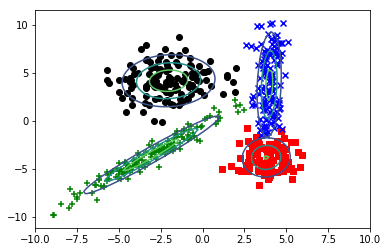

In [22]:
pi, mus, Sigmas, tau = EM_mixture(data_train)
print(tau)
plot_model(data_train, tau, mus, Sigmas)
plt.show()

In [23]:
print("Train loglikelihood = %f" % avg_log_likelihood_mixture(data_train, pi, mus, Sigmas))

Train loglikelihood = -4.655431


9 / Compute the log-likelihood of the test data, visualize the data and comment.

In [24]:
tau = E_step_mixture(data_test, pi, mus, Sigmas)
plot_model(data_test, tau, mus, Sigmas)
print("Test loglikelihood = %f" % avg_log_likelihood_mixture(data_test, pi, mus, Sigmas))

(500, 4)
Test loglikelihood = -4.817959


# 4 Hidden Markov Model

10 / We now take into account the temporal structure of the data with a chain-structured hidden Markov model with discrete latent variable $z\in\{0,\cdots,K-1\}^T$:
$$
p(x, z) = p(z_0)\prod_{t=0}^{T-1}  p(x_t \mid z_t)\prod_{t=1}^{T-1} p(z_t \mid z_{t-1}).
$$
We model $p(x_t \mid z_t = k) \sim \mathcal{N}(\mu_k, \Sigma_k)$ like in the previous model, and $p(z_{t+1}=k \mid z_{t}=l)=A_{k,l}$ and finally $p(z_0)$ with a multinomial distribution parameterized by $\pi_0$.

We initialize the Gaussian parameters $\mu_k$ and $\Sigma_k$ with the values $\hat{\mu_k}$ and $\hat{\Sigma_k}$ computed in the mixture model. We initalize $\pi_0$ and $A$ as follows:
$$
\pi_0=\hat{\pi}
$$

$$
[A]_{k,l}=\hat{\pi}_k
$$
Complete the next cell to initialize $A$ and $\pi_0$. <font color = red> How can we interpret this initialization?

### Ans
Pi0 is a vector that contains  the initial probability belief of starting in each of the four states. When in any of the four states, then $a_{k,l}$ is the probability of transitioning from state k to another l. These probability values make up a stochastic matrix called the transition probability $[A]_{k,l}$. Also $[A]_{k,l}$ is made up of a stack of pi0 supporting our assumption that transition from one state to any other state is equally likely hence equal probabilities in each row. The sum of the probabilities in each row is also required to sum up to one. The total number of rows corresponds to the number of states assumed in the model.

In [25]:
#A = #TODO
pi0 = pi
A=np.array([pi]*(pi.shape[0])).T ## np.tile()

print(A.shape)
A,pi


(4, 4)


(array([[0.2515573 , 0.2515573 , 0.2515573 , 0.2515573 ],
        [0.18292071, 0.18292071, 0.18292071, 0.18292071],
        [0.30555635, 0.30555635, 0.30555635, 0.30555635],
        [0.25996564, 0.25996564, 0.25996564, 0.25996564]]),
 array([0.2515573 , 0.18292071, 0.30555635, 0.25996564]))

10 / Complete the function $\texttt{alpha_beta}(x, pi,mus,Sigmas, A)$ which peforms the marginal inference of the model.

we have the following formulas for the alpha and beta recursions:
$$
\alpha(z_{t}) = p(x_0, \cdots, x_t, z_t)  = p(x_t \mid z_t)\sum_{z_{t-1}=0}^{K-1}\alpha(z_{t-1})\;p(z_{t} \mid z_{t-1})
$$
$$
\beta(z_{t}) = p(x_{t+1}, \cdots, x_T \mid z_t) = \sum_{z_{t+1}=0}^{K-1}\beta(z_{t+1})\;p(z_{t+1}\mid z_{t})\;p(x_t \mid z_{t})
$$

In [26]:
def alpha_beta(x, pi0, mus, Sigmas, A):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    outputs:
    log_proba_emission : [T,K] the probability that each data point x_t was generated by the k-th mixture
    alpha, beta : [T,K] 
    """
    T = x.shape[0]
    log_proba_emission = log_all_gaussians(x, mus, Sigmas)

    #forward pass
    log_alpha = np.zeros((T, n_state), dtype=('f8'))
    
    log_alpha[0,:] = log_proba_emission[0] + np.log(pi0)[None,:]
    
    for t in range(1,T):
        
        log_alpha[t,] = (log_proba_emission[t] + logsumexp(log_alpha[t-1,] + np.log(A.T)) )[None,:]
        
    #backward pass
    log_beta = np.zeros((T, n_state), dtype=('f8')) 
    
    for t in range(T-2,-1,-1):
        
        log_beta[t,] = logsumexp((log_beta[t+1,] +np.log(A) + (log_proba_emission[t+1,])))
        
    return log_proba_emission, log_alpha, log_beta

In [27]:
log_proba_emission, log_alpha, log_beta = alpha_beta(data_train, pi0, mus, Sigmas, A)
log_proba_emission,log_alpha,log_beta

(array([[  -7.84425894,  -10.92309517,   -3.58558667,  -24.67320673],
        [  -4.11374969,  -55.69984689, -150.85187792, -108.99290761],
        [ -12.44757634,  -41.68701689,  -41.27325126,   -3.33506725],
        ...,
        [  -6.87463115,  -14.0694348 ,   -3.52961617,  -37.51155877],
        [ -26.40088874,  -65.49640621,   -4.29995809, -285.11524541],
        [  -9.72500542,  -19.95672816,   -2.47246828,  -79.61865839]]),
 array([[   -9.22434341,   -12.62179767,    -4.77120773,   -26.02041255],
        [  -10.06080859,   -61.64690579,  -156.79893683,  -114.93996652],
        [  -23.88846941,   -53.12790996,   -52.71414433,   -14.77596032],
        ...,
        [-2321.94842548, -2329.14322913, -2318.60341051, -2352.5853531 ],
        [-2346.16128979, -2385.25680726, -2324.06035915, -2604.87564646],
        [-2334.97098563, -2345.20270837, -2327.71844849, -2404.8646386 ]]),
 array([[-2323.15076591, -2323.46938395, -2322.9563025 , -2323.11788725],
        [-2317.65693175, -2317.9

11 / Compute the first order marginal probability $\gamma_t= {p(z_t \mid x)}$. Check that the normalization factor is the same for all $t$. Why is that the case? 
Reminder:
$$
\gamma(z_t)=p(z_t \mid x) \propto {\alpha(z_t)\beta(z_t)}
$$

In [28]:
#marginal inference - first order
log_gamma_unnormalized = log_alpha + log_beta


normalizing_factor =logsumexp(log_gamma_unnormalized)
print(normalizing_factor.shape)

log_gamma = log_gamma_unnormalized - normalizing_factor[:,None]

#check that the normalizing factor is indeed constant

assert((np.abs(normalizing_factor.std())<1e-8).all())
normalizing_factor

(500,)


array([-2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
       -2327.71774034, -2327.71774034, -2327.71774034, -2327.71774034,
      

Plot the evolution of the most likely state for each of the first 100 point and comment. <font color = red> How good was our initialization of $A$?

### Ans:
Before running the HMM on the dataset, it's first trained with the Mixture model. This allows us to find a good set of parameters including the transition probability. Although the HMM may not converge to a global Maximum, it converges to a better local optimum with a higher likelihood.

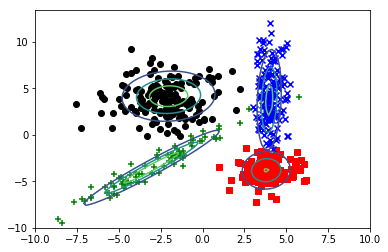

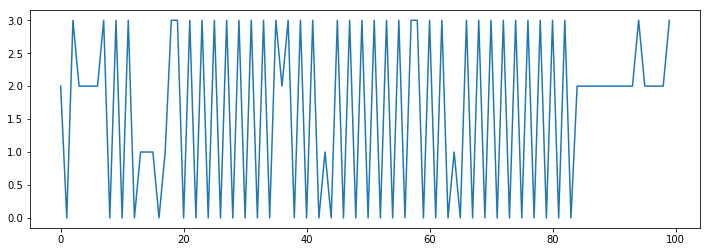

In [29]:
#z:TO DO
z=log_gamma.argmax(1)
figure(figsize=(12,4))
plt.plot(z[0:100])
plt.show()

12 / Compute the pairwise marginals $\xi(z_{t-1},z_t)=p(z_{t-1},z_{t} \mid x; \theta_\text{current})$.

Reminder:
$$
\xi(z_{t-1},z_t)= \frac{\alpha(z_{t-1}) p(x_t \mid z_t; \theta_\text{current}) p(z_t \mid z_{t-1}; \theta_\text{current}) \beta(z_t)}{p(x; \theta_\text{current})}
$$

In [30]:

log_xi = log_alpha[0:-1,:][:,:,None] + log_proba_emission[1:,:][:,None,:] + np.log(A)[None,:,:]+ log_beta[1:,:][:,None,:] - normalizing_factor[0] #+ #TODO
print(log_xi.shape)
#log_beta[1:log_alpha.shape[0],:][:,None].shape
#code check: the pair marginals are indeed probabilities
assert((np.abs(np.exp(log_xi).sum(1).sum(1)-1)<1e-10).all())
#np.exp(log_xi).sum(1).sum(1)

(499, 4, 4)


13 / Complete the function $\texttt{E_step_HMM}(pi,mus,Sigmas, A)$ which returns the singleton and pairwise marginals as well as the averaged loglikelihood of the observation.

In [31]:
def E_step_HMM(x, pi0, mus,Sigmas, A):
    """
    inputs:
    x : [T,D] T input points of dimension D
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    outputs:
    log_gamma : [T,K] marginals
    log_xi : [T, K, K] patwise marginals
    avg likelihood, float
    """
    #
    log_proba_emission, log_alpha, log_beta = alpha_beta(x,pi0,mus,Sigmas,A)
    
    log_gamma_unnormalized = log_alpha + log_beta
    
    log_likelihood= logsumexp(log_gamma_unnormalized)[:,None]
    
    log_gamma = log_gamma_unnormalized - log_likelihood
    
    log_xi = log_alpha[0:-1,:][:,:,None] + log_proba_emission[1:,:][:,None,:] + np.log(A)[None,:,:]+ log_beta[1:,:][:,None,:] - log_likelihood[0]
   # return log_gamma, log_xi, log_likelihood[0]/x.shape[0]
    return log_gamma, log_xi, log_likelihood[0]/x.shape[0]

14 / Complete the function $\texttt{M_step_HMM}(\gamma, \xi)$ for the HMM model which returns the parameters $\hat{\mu}_k,\hat{\Sigma}_k, \hat{A}$.

$$
[\hat{A}]_{k,l}=\frac{\sum_{t=0}^{T-2}p(z_{t+1}=k,z_{t}=l \mid x; \theta_\text{current})}{\sum_{t=0}^{T-2}\sum_{j=0}^{K-1} p(z_{t+1}=j,z_{t}=l \mid x; \theta_\text{current})}
$$

In [32]:
(np.exp(log_xi).sum(0)/np.exp(logsumexp(log_xi.T)).sum(1)).sum(0)

array([1., 1., 1., 1.])

In [33]:
def M_step_HMM(x, log_gamma, log_xi):
    """
    inputs:
    x: [T,D] T input points of dimension D
    log_gamma [T,K] marginals
    log_xi [T, K, K] patwise marginals
    outputs:
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    """
    
    pi, mus, Sigmas = M_step_mixture(x,np.exp(log_gamma))
    
    A=np.exp(log_xi).sum(0)/(np.exp(logsumexp(log_xi.T)).sum(1))
    
    #print(A,A.shape,A.sum(0))
    
    pi0 = np.exp(log_gamma[0,:])
    
    return pi0, mus, Sigmas, A

In [34]:
pi0, mus, Sigmas, A =  M_step_HMM(data_train, log_gamma, log_xi)
print(A.sum(0))
print(A)
#a code check that A is indeed a conditional probability
assert(np.all(np.abs(A.sum(0)-1)<1e-10))
pi0

[1. 1. 1. 1.]
[[0.01858843 0.1487509  0.06234191 0.77217593]
 [0.10125221 0.72723956 0.01917633 0.07155853]
 [0.02182063 0.05266632 0.85943503 0.10590672]
 [0.85833874 0.07134322 0.05904673 0.05035881]]


array([9.49140161e-03, 2.30919527e-04, 9.90277678e-01, 4.97931072e-10])

16 / Implement the EM algorithm for the HMM model. Initialize the parameters with EM on the Gaussian mixture model.

(500, 4)
Mixture iteration 0  - loglikelihood = -4.784
(500, 4)
Mixture iteration 1  - loglikelihood = -4.712
(500, 4)
Mixture iteration 2  - loglikelihood = -4.678
(500, 4)
Mixture iteration 3  - loglikelihood = -4.669
(500, 4)
Mixture iteration 4  - loglikelihood = -4.665
(500, 4)
Mixture iteration 5  - loglikelihood = -4.662
(500, 4)
Mixture iteration 6  - loglikelihood = -4.660
(500, 4)
Mixture iteration 7  - loglikelihood = -4.659
(500, 4)
Mixture iteration 8  - loglikelihood = -4.658
(500, 4)
Mixture iteration 9  - loglikelihood = -4.657
(500, 4)
Mixture iteration 10  - loglikelihood = -4.657
(500, 4)
Mixture iteration 11  - loglikelihood = -4.656
(500, 4)
Mixture iteration 12  - loglikelihood = -4.656
(500, 4)
Mixture iteration 13  - loglikelihood = -4.656
(500, 4)
Mixture iteration 14  - loglikelihood = -4.656
(500, 4)
Mixture iteration 15  - loglikelihood = -4.656
(500, 4)
Mixture iteration 16  - loglikelihood = -4.656
(500, 4)
Mixture iteration 17  - loglikelihood = -4.656
(5

/usr/lib/python3/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log


HMM iteration 45  - likelihood = -3.794
HMM iteration 46  - likelihood = -3.794
HMM iteration 47  - likelihood = -3.794
HMM iteration 48  - likelihood = -3.794
HMM iteration 49  - likelihood = -3.794
HMM iteration 50  - likelihood = -3.794
HMM iteration 51  - likelihood = -3.794
HMM iteration 52  - likelihood = -3.794
HMM iteration 53  - likelihood = -3.794
HMM iteration 54  - likelihood = -3.794
HMM iteration 55  - likelihood = -3.794
HMM iteration 56  - likelihood = -3.794
HMM iteration 57  - likelihood = -3.794
HMM iteration 58  - likelihood = -3.794
HMM iteration 59  - likelihood = -3.794
HMM iteration 60  - likelihood = -3.794
HMM iteration 61  - likelihood = -3.794
HMM iteration 62  - likelihood = -3.794
HMM iteration 63  - likelihood = -3.794
HMM iteration 64  - likelihood = -3.794
HMM iteration 65  - likelihood = -3.794
HMM iteration 66  - likelihood = -3.794
HMM iteration 67  - likelihood = -3.794
HMM iteration 68  - likelihood = -3.794
HMM iteration 69  - likelihood = -3.794


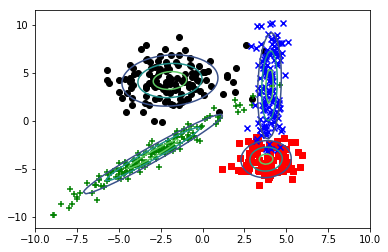

In [35]:
#init with mixture
pi, mus, Sigmas, tau = EM_mixture(data_train)
A = np.tile(pi, (n_state,1))
pi0 = pi
n_ite = 100
#main loop
for i_ite in range(100):    
    #E-step
    log_gamma, log_xi, log_likelihood = E_step_HMM(data_train,pi0,mus,Sigmas,A)
    print("HMM iteration %d  - likelihood = %1.3f" % (i_ite, log_likelihood))
    #M-step
    pi0, mus, Sigmas, A = M_step_HMM(data_train,log_gamma,log_xi)
    
plot_model(data_train, np.exp(log_gamma), mus, Sigmas)
plt.show()

18/ Compute the final loglikelihood on the training set and compare it to the one obtained with the mixture model. <font color='red'> Is it a surprising result? Explain why? Make the same comparison on the test set. What conclusion can we draw now?</font>

### Ans
The final log-likelihood for the HMM Expectation Maximisation on train data is greater than the mixture model one. This validates the fact that the HMM algorithm fits the data better and converges to a value much clo. The same can also be said of the test data modelled with the HMM as they showed a significantly high log-likelihood compared to the mixture model. Again, the difference between the train and test log-likelihoods for the HMM is very low compared to that of the Mixture model. This is a possible implication that the HMM model assigns a much higher likelihood even to the unseen sequence and not just the seen. It can therefore be concluded that the HMM algorithm finds a locally-optimal point with respect to the log-likelihood

In [36]:
_log_gamma, _log_xi, log_likelihood_train = E_step_HMM(data_train, pi0, mus, Sigmas, A)

_log_gamma, _log_xi, log_likelihood_test = E_step_HMM(data_test, pi0, mus, Sigmas, A)

print("likelihood train %1.3f  - likelihood test= %1.3f" % (log_likelihood_train, log_likelihood_test))

likelihood train -3.794  - likelihood test= -3.910


/usr/lib/python3/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log


19/ <font color = red> If we didn't know in advance the number of states, how would we choose it?

### Ans:

There are many ways of arriving at a good K that best explains the data. This includes model selection criteria such as Bayesian Information Criterion, Minimum Description Length and sequential pruning strategy. The later involves initialising the K with a maximum and a minimum. The maximum number is then used to estimate the parameters and trained until the minimum number of states. Pruning is  done by decreasing steps during training. This method will then arrive at the optimum number of states that fit the data very well.

20 / Implement the Viterbi algorithm for MAP inference / decoding. <font color = red> Explain the difference between marginal and MAP inference.
</font>

Reminder:
the Viterbi algorithm is also called max-product. It computes the sequence of state with the maximum likelihood. It defines $p^\text{map}_{t,i}$ as the probability that the most probable path $0\cdots,t$ end in state $i$. We have the following recursion:
$$
p^\text{map}_{t,i} = p(x_t,z_t=i;\theta_\text{current}) \;\max_j( p^\text{map}_{t-1,j}\; p(z_t=i \mid z_{t-1}=j;\theta_\text{current})
$$
Once $p^\text{map}_{T,i}$ is computed, the last state of the map sequence is $\text{argmax}(p^\text{map}_{T,i})$. To compute the previous state, one simply backtrack through the selected transition computed earlier (keep track of the argmax!).

### Ans

With marginal inference, we compute the conditional probability of a given variable(s) in a joint distribution by summing all probability values out over all other variables. Examples of marginal inference includes belief propagation in forward step of the Hidden Markov Model where P(x) is found by marginalising over all paths. Also in Maximum a posteriori Inference, we find the most likely assignment to the unobserved variables that maximises a posterior distribution given the observed variables and this involves taking the max of the probability of the unobserved variables given the observed. The Viterbi algorithm is an example of one for MAP inference



Reminder:
the Viterbi algorithm is also called max-product. It computes the sequence of state with the maximum likelihood. It defines $p^\text{map}_{t,i}$ as the probability that the most probable path $0\cdots,t$ end in state $i$. We have the following recursion:
$$
p^\text{map}_{t,i} = p(x_t,z_t=i;\theta_\text{current}) \;\max_j( p^\text{map}_{t-1,j}\; p(z_t=i \mid z_{t-1}=j;\theta_\text{current})
$$
Once $p^\text{map}_{T,i}$ is computed, the last state of the map sequence is $\text{argmax}(p^\text{map}_{T,i})$. To compute the previous state, one simply backtrack through the selected transition computed earlier (keep track of the argmax!).

In [37]:
def viterbi(x, pi0, mus, Sigmas, A):
    """
    inputs:
    pi0 : [K,] initial Multinomial
    mus : [K,D] the K centroids
    Sigmas : [K,D,D] the K covariances
    A : [K,K] transition probability
    outputs:
    map_state T, the MAP affectation
    best_previous_state : the argmax of each max-product
    """
    T = x.shape[0]
    
    log_proba_emission= log_all_gaussians(x, mus, Sigmas)
    
    #print(log_proba_emission)
    
    map_state = np.zeros((T,), dtype='uint8') #the map sequence
    
    best_proba = np.zeros((T,n_state), dtype='f8') #probability of best sequence 1..t being in state i
    
    best_previous_state = np.zeros((T,n_state), dtype='uint8') #state of the previous observation in the best sequence 1..t
    #init
    best_proba[0,:] = log_proba_emission[0] + np.log(pi0)
    
    best_previous_state[0,:] = np.NaN #no previous observation
    
    #forward pass
    for t in range(1,T):
    
        proba_previous_state = np.log(A) + best_proba[t-1,:]
        
        best_proba[t,] = log_proba_emission[t] + np.max(proba_previous_state)
            
        best_previous_state[t,] = np.argmax(proba_previous_state,1)
        
    #backward pass
    map_state[-1] = best_proba[-1,:].argmax()
    for t in range(T-2,0,-1):#backtrack
        
        map_state[t] = best_proba[t].argmax()
        
        #map_state[t] = best_previous_state[t-1,:].argmax()
        
    return map_state, best_previous_state

In [38]:
map_state, best_previous_state = viterbi(data_train, pi0, mus,Sigmas, A)
plot_affectation(data_train, map_state)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log


21 / Launch the visualiziation below representing the backtracking of the Viterbi algorithm. Interpret and comment.

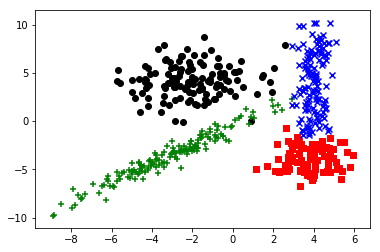

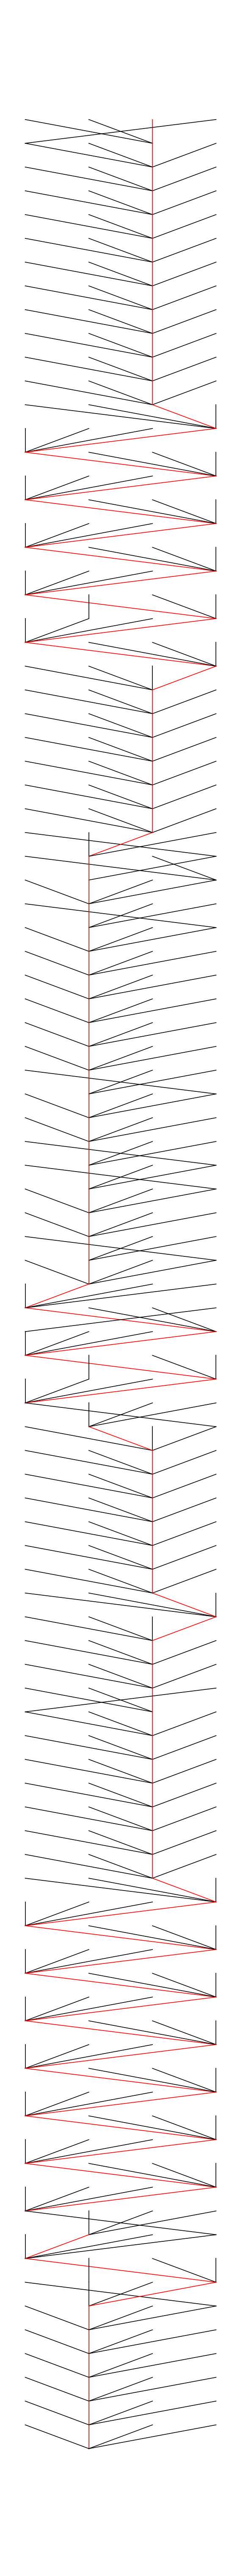

In [39]:
figure(num=None, figsize=(8, 100), dpi=80, facecolor='w', edgecolor='k')
plt.axis('off')
for t in range(n_point-2,n_point-100,-1):
    for i_state in range(n_state):
        if best_previous_state[t,i_state]==map_state[t-1] and i_state==map_state[t]:
            c = 'r'
        else:
            c = 'k'
        plt.plot([i_state, best_previous_state[t,i_state]],[t, t-1], c)
best_previous_state[-10:-1,:] 
plt.show()